---
# Python 人工智能入门 毕业项目
# 大盘指数预测
## 黄祯鑫
## 2019年7月30日
---


## 目录
<ul>
<li><a href="#definition">定义</a></li>
<li><a href="#analysis">分析</a></li>
<li><a href="#implementation">实现</a></li>
<li><a href="#result">结果</a></li>
<li><a href="#conclusion">结论</a></li>   
</ul>



---
<a id="definition"></a>
## Ⅰ.定义

### 1.项目概况

股票市场是投资的一个重要渠道，但是股市的涨跌看似没有任何规律，如果能预测大盘的涨跌，择机买入或卖出，从而获得收益。
我们从[优矿网站](https://uqer.io/)导出了2006-3-1到2015-3-1期间每交易日沪深300指数的最高价、最低价、收盘价、成交量等信息，具体如下:
- tradeDate: 交易日 
- closeIndex: 收盘指数
- highestIndex: 当日最大指数
- lowestIndex: 当日最小指数
- turnoverVol: 收盘交易量
- CHG: 涨跌点数（与上一交易日收盘指数比较，正数为涨，负数为跌）
- CHGPct: 涨跌百分比（与上一交易日收盘指数比较，正数为涨，负数为跌）

使用此数据集来训练和测试一个模型，并对模型的性能和预测能力进行测试。
### 2.问题陈述

可以了解到，收盘价、最低价、最高价、成交量等特征都是当前交易日结束后的统计值，我们需要预测的是下个交易日假设当日收盘时我们以收盘价买入，下一交易日以收盘价卖出，二者的差值即获得的收益，收益/成本为收益率。
分析数据集特征，将数据集拆分为训练集和测试集，使用sklearn拟合线性回归模型，调整参数并解释结果，最后使用交叉验证评估模型。
使用模型预测结果，当收益率大于零时买入。
### 3.评价指标

R2score指标可以衡量自变量对因变量的解释程度，R2score的值为0-1之间，越接近1表明拟合度越高。通过在训练集上拟合模型，在测试集上计算模型的R2score评价模型。

---
<a id="analysis"></a>
## Ⅱ.分析



In [277]:
#导入需要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm;
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

%matplotlib inline

#加载数据
df = pd.read_csv('data.csv', index_col=0)
#观察前几条数据
df.head()

,tradeDate,closeIndex,highestIndex,lowestIndex,turnoverVol,CHG,CHGPct
0,2006-03-01,1056.62,1057.69,1049.64,1942573000,3.61,0.003428
1,2006-03-02,1038.67,1056.05,1034.68,2487786100,-17.95,-0.016988
2,2006-03-03,1041.68,1043.42,1029.56,2120053900,3.01,0.002898
3,2006-03-06,1038.87,1044.42,1036.11,1787096300,-2.81,-0.002698
4,2006-03-07,1014.97,1037.98,1013.14,1933651600,-23.90,-0.023006


In [278]:
#观察到tradeDate列为日期，可以使用日期作为索引
df['tradeDate'] = pd.to_datetime(df['tradeDate'])
df.set_index("tradeDate", inplace=True)
df.head()

,closeIndex,highestIndex,lowestIndex,turnoverVol,CHG,CHGPct
tradeDate,,,,,,
2006-03-01,1056.62,1057.69,1049.64,1942573000,3.61,0.003428
2006-03-02,1038.67,1056.05,1034.68,2487786100,-17.95,-0.016988
2006-03-03,1041.68,1043.42,1029.56,2120053900,3.01,0.002898
2006-03-06,1038.87,1044.42,1036.11,1787096300,-2.81,-0.002698
2006-03-07,1014.97,1037.98,1013.14,1933651600,-23.90,-0.023006


In [279]:
#数值特征
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2187 entries, 2006-03-01 to 2015-02-27
Data columns (total 6 columns):
closeIndex      2187 non-null float64
highestIndex    2187 non-null float64
lowestIndex     2187 non-null float64
turnoverVol     2187 non-null int64
CHG             2187 non-null float64
CHGPct          2187 non-null float64
dtypes: float64(5), int64(1)
memory usage: 119.6 KB


In [280]:
#统计信息
df.describe()

,closeIndex,highestIndex,lowestIndex,turnoverVol,CHG,CHGPct
count,2187.000000,2187.000000,2187.000000,2.187000e+03,2187.000000,2187.000000
mean,2787.469758,2816.014321,2752.490402,6.939017e+09,1.152186,0.000732
std,897.538722,910.123885,881.555628,5.389863e+09,58.216027,0.018595
min,1004.340000,1010.910000,999.930000,1.134803e+09,-391.860000,-0.092400
25%,2287.135000,2307.990000,2259.585000,3.998628e+09,-21.330000,-0.008226
50%,2608.570000,2628.700000,2584.760000,5.794680e+09,2.900000,0.001100
75%,3222.340000,3253.935000,3178.845000,8.159082e+09,27.075000,0.010603
max,5877.200000,5891.720000,5815.610000,6.328746e+10,378.180000,0.093418


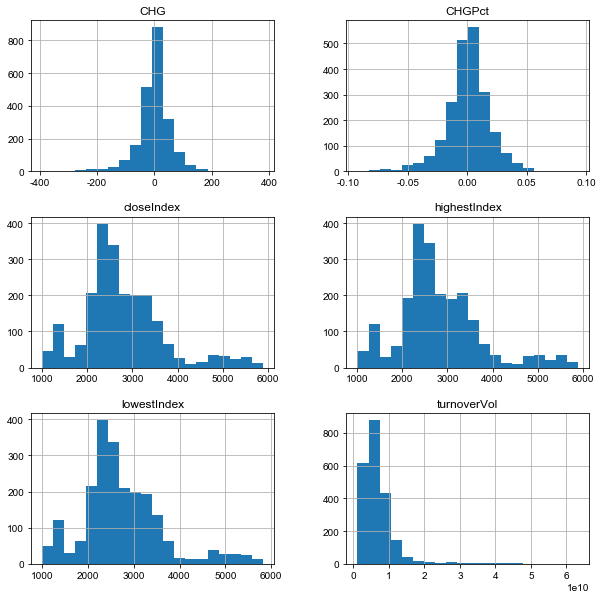

In [281]:
df.hist(figsize=(10,10),bins = 20);

In [282]:
df.corr()

,closeIndex,highestIndex,lowestIndex,turnoverVol,CHG,CHGPct
closeIndex,1.000000,0.999167,0.999206,0.152082,0.021975,0.008433
highestIndex,0.999167,1.000000,0.998993,0.152739,-0.010796,-0.021710
lowestIndex,0.999206,0.998993,1.000000,0.147516,-0.003346,-0.016771
turnoverVol,0.152082,0.152739,0.147516,1.000000,0.103710,0.109801
CHG,0.021975,-0.010796,-0.003346,0.103710,1.000000,0.950750
CHGPct,0.008433,-0.021710,-0.016771,0.109801,0.950750,1.000000


**(你的回答)**

### 1.数据的探索
观察到turnoverVol为整型，其他特征均为浮点型，且无空值。turnoverVol的数值均为很大的数字，均值为69亿，CHGPct的数值很小，均值只有0.000732。
closeIndex是介于highestIndex与lowestIndex之间的值，且值比较接近，因为我们只关注closeIndex，所以计算highestIndex-lowestIndex与closeIndex的比值得到新的特征列，舍弃highestIndex与lowestIndex两列。
turnoverVol特征最大值与75%分位值差距较大，约为8倍，可能存在异常值。
CHG 为绝对的涨跌点数，CHGPct 为 CHG 与closeIndex的除数，应舍弃 CHG 特征列。
CHGPct最小值与25%分位值相差约11倍，最大值与75%分位值相差约9倍，可能存在异常值。


### 2.探索性可视化
通过可视化看到，CHG与CHGPct呈正态分布，turnoverVol呈右偏态,turnoverVol的分布图可以明显看出右侧有离群值

### 3.算法和技术
根据观察到的特点，线性回归需要用 log 函数将数据从偏态分布转换为正态分布，并进行标准化。


---
<a id="implementation"></a>
## Ⅲ. 实现


In [283]:
#计算当日波动率百分比并记录在'volatility'列
df_new = pd.DataFrame(df)
df_new['volatility'] = (df_new['highestIndex'] - df_new['lowestIndex'])/df_new['closeIndex']

df_new.drop(df_new[df_new['CHGPct'] > 0.05].index, inplace = True)
df_new.drop(df_new[df_new['CHGPct'] < -0.05].index, inplace = True)
df_new.drop(df_new[df_new['turnoverVol'] > 20000000000].index, inplace = True)


#因为预测的是下一交易日的涨跌，所以需要把「CHG」列上移一行，并删除空值
df_new['CHGPct_Next'] = df_new['CHGPct'].shift(-1)
df_new.dropna(inplace=True)

In [284]:
#删除不必要的特征列
df_new.drop(['highestIndex', 'lowestIndex', 'CHG'], axis=1, inplace = True)

In [285]:
#处理后的数据量与原数据量比较，避免丢弃过多数据
df_new.shape[0]/df.shape[0]

0.9529035208047554

In [286]:
df_new.head()

,closeIndex,turnoverVol,CHGPct,volatility,CHGPct_Next
tradeDate,,,,,
2006-03-01,1056.62,1942573000,0.003428,0.007619,-0.016988
2006-03-02,1038.67,2487786100,-0.016988,0.020574,0.002898
2006-03-03,1041.68,2120053900,0.002898,0.013305,-0.002698
2006-03-06,1038.87,1787096300,-0.002698,0.007999,-0.023006
2006-03-07,1014.97,1933651600,-0.023006,0.024474,-0.005616


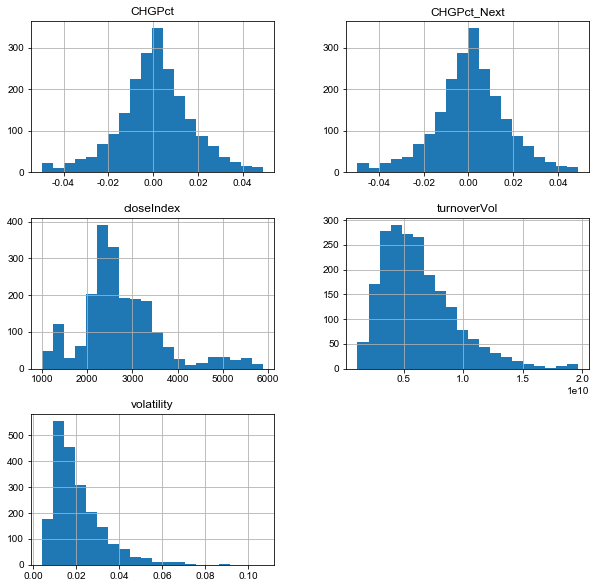

In [287]:
df_new.hist(figsize=(10,10),bins = 20);

In [288]:
#删除volatility异常值
df_new.drop(df_new[df_new['volatility'] > 0.08].index, inplace = True)

In [289]:
#训练模型并得到分数
def fitmodel(X, y):   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
    model = LinearRegression(n_jobs = 100)
    model.fit(X_train, y_train);
    print('score: ',model.score(X_test, y_test))
    return model

In [290]:
#直接训练得分
X = df_new.drop(['CHGPct_Next'], axis=1)
y = df_new['CHGPct_Next']
model = fitmodel(X, y)

score:  0.007086179557698746


In [291]:
#使用log将数据从偏态分布转换为正态分布
df_std = pd.DataFrame(df_new)
df_std['turnoverVol'] = np.log10(df_std['turnoverVol'])
df_std['volatility'] = np.log10(df_std['volatility'])
df_std['closeIndex'] = np.log10(df_std['closeIndex'])

In [292]:
#标准化
numeric_features = list(df_std.columns)
numeric_features.remove('CHGPct_Next')
scaler = StandardScaler()
scaler.fit(df_std[numeric_features])
df_std[numeric_features] = scaler.transform(df_std[numeric_features])

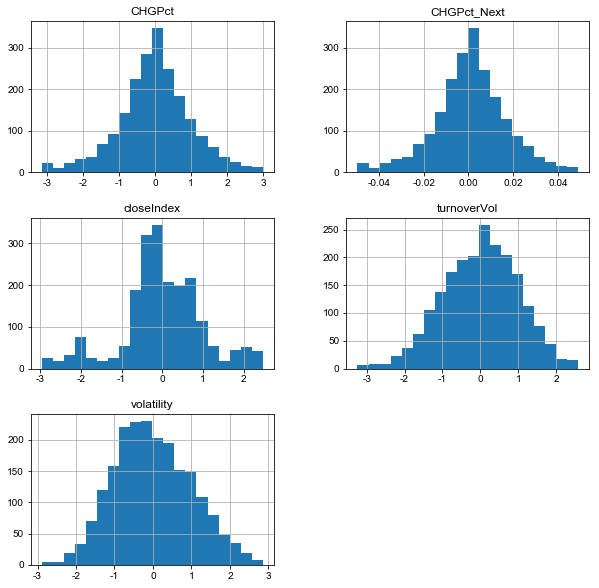

In [293]:
df_std.hist(figsize=(10,10),bins = 20);

In [294]:
#进行标准化后训练得分
X = df_std.drop(['CHGPct_Next'], axis=1)
y = df_std['CHGPct_Next']
model = fitmodel(X, y)

score:  0.016707170733649357


**(你的回答)**

### 1.数据预处理
计算当日波动率百分比并记录在'volatility'列
因为预测的是下一交易日的涨跌，所以需要把「CHG」列上移一行，并删除空值
整理好原数据集后，删除不必要的特征列保存在新的对象中，比较处理后的数据量与原数据量，避免丢弃过多数据。

因为我们筛选出来的特征都为数值类型特征，所以我们只做标准化的操作：这个项目是一个回归类型的项目，而我们的回归算法对标准正态分步预测较为准确，从我们的目标数据可以看出数据是一个偏态分布，那么我们使用log将数据从偏态分布转换为标准正态分布，最后进行标准化。

### 2.执行过程

将数据集划分为训练集和测试集，使用训练集训练模型，在测试集上得分

### 3.完善

使用原始数据得分0.007，进行标准化后训练得分0.0167


---
<a id="result"></a>
## IV. 结果


In [295]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

def score(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

    #使用 K 折交叉验证计算得分均值
    kfold = model_selection.KFold(n_splits=5, random_state=5);
    model = LinearRegression();
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2');
    print('kFoldscore: ',results.mean())


In [296]:
X = df_std.drop(['CHGPct_Next'], axis=1)
y = df_std['CHGPct_Next']
score(X, y)

kFoldscore:  0.0029835736902720455


**(你的回答)**
### 模型的评价与验证

使用 K 折交叉验证计算得分均值得到极低的分数，说明模型并不能预测结果，使用 K 折交叉验证计算得分均值甚至比之前模型的得分更低，说明模型有一定偶然性

---
<a id="conclusion"></a>
## V. 项目结论



### 结果可视化


score:  0.016707170733649357


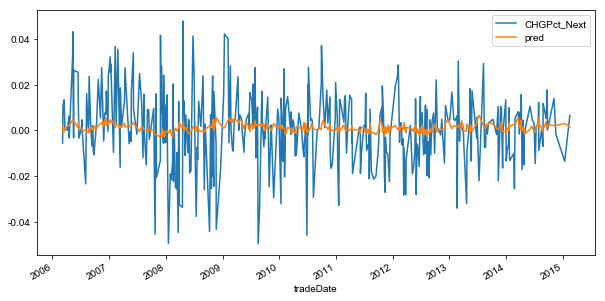

In [297]:
X = df_new.drop(['CHGPct_Next'], axis=1)
y = df_new['CHGPct_Next']
model = fitmodel(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
pred = model.predict(X_test)
df_pred = y_test.to_frame()
df_pred['pred'] = pred
df_pred.plot(figsize=(10,5));

上图可看出预测值在0附近很小的波动，实际值在0附近较大波动，对于我们做决策没有帮助。

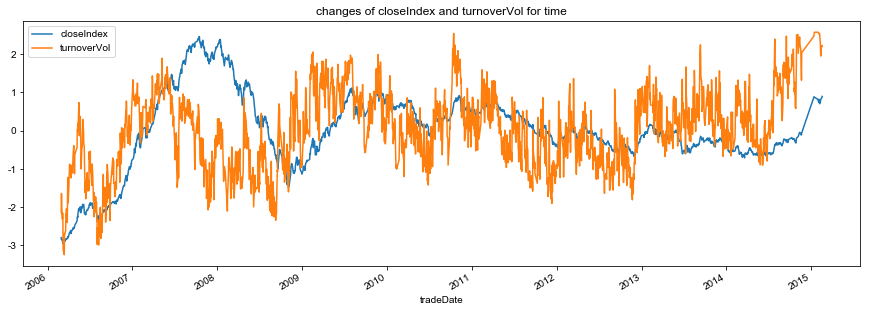

In [298]:
#使用标准化后的数据绘制收盘价和成交量的折线图
df_std.plot(y=['closeIndex', 'turnoverVol'],figsize=(15,5), title='changes of closeIndex and turnoverVol for time');

虽然相关性数值显示二者为弱相关，但从图表看随时间变化二者应有更强的相关性。

### 对项目的思考

In [299]:
#开始时我们设定的预测目标是第二天相比前一天涨跌的百分比，而根据前一天的收盘价和第二天的涨跌百分比可以计算出第二天的收盘价，
#如果改为预测第二天收盘价，模型表现如何呢？
df_close = df.drop(['highestIndex', 'lowestIndex', 'CHG'], axis=1)
df_close['closeIndex_Next'] = df['closeIndex'].shift(-1)
df_close.dropna(inplace=True)
X = df_close.drop(['closeIndex_Next'], axis=1)
y = df_close['closeIndex_Next']
model = fitmodel(X, y)
score(X, y)

score:  0.9957818159074543
kFoldscore:  0.995814228389048


In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
pred = model.predict(X_test)
df_pred = y_test.to_frame()
df_pred['pred'] = pred
df_pred.sample(5, random_state=5)

,closeIndex_Next,pred
tradeDate,,
2006-09-14,1362.32,1342.855736
2009-01-07,1887.99,1933.427139
2009-08-03,3786.62,3785.448903
2012-07-02,2468.72,2462.205638
2014-08-12,2358.90,2356.489561


In [301]:
df.loc['2009-01-07']

closeIndex      1.931180e+03
highestIndex    1.959250e+03
lowestIndex     1.930870e+03
turnoverVol     5.970217e+09
CHG            -1.162000e+01
CHGPct         -5.981000e-03
volatility      1.469568e-02
Name: 2009-01-07 00:00:00, dtype: float64

2009-01-07当日收盘为1931，下一日预测收盘1933，实际收盘1887，也就是说预测下跌实际上涨。

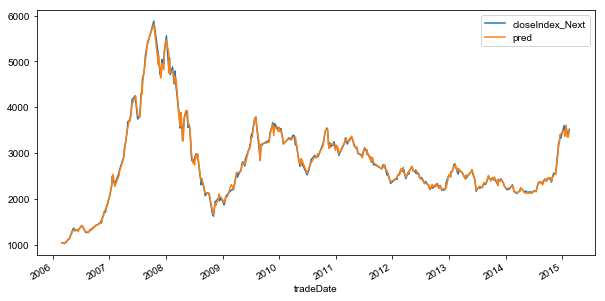

In [302]:
df_pred.plot(figsize=(10,5));

似乎拟合的很好，根据预测的收盘价计算出涨跌百分比是否与实际值一致

In [303]:
df_pred['closeIndex'] = X_test['closeIndex']
df_pred['pred_CHGPct'] = (df_pred['pred'] - df_pred['closeIndex'])/df_pred['closeIndex']
df_pred['CHGPct'] = X_test['CHGPct']

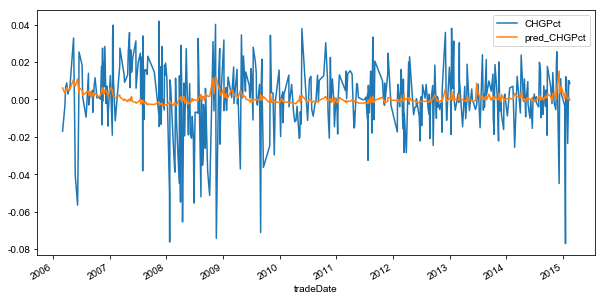

In [304]:
df_pred.plot(y=['CHGPct', 'pred_CHGPct'], figsize=(10,5));

可以看出和最初模型的结果相似，预测值在0附近有很小的波动，而实际值在0附近较大波动

### 需要作出的改进


**(你的回答)**
改变预测的目标，模型得分表现相反，但实际上预测结果类似，我们可能需要考虑相关误差的影响。
随时间变化来收集的数据（比如预测未来股价或利率）很容易出现相关误差。通常，我们可以用过去数据点提供的信息（针对与时间有关的数据）来提高预测结果。
如 ARIMA 或 ARMA 模型，人们常用这两个模型来利用误差相关性，以便做出更佳预测。